<a href="https://colab.research.google.com/github/andr3w1699/Intelligent_System_for_Pattern_Recognition/blob/main/FirstAssignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First ISPR Assignement: Signal Processing, Assignement number 2
# Author: Andrea Lepori


Assignement 2:

Consider the following dataset: https://www.kaggle.com/datasets/imsparsh/single-chestmounted-accelerometer

It contains accellerometer timeseries for 15 participants performing 7 different physical activities.

For this assignement focus on a single participant (of your choice) and study its 7 different activities using the Continous Wavelet Decomposition (CWD) approach discussed during the lectures. It suffices to compare the CWD visually and report you considerations on similarities and differences between the activities.

Note: you need to run the CDW separately for each accelerator channel. You can choose the wavelet family you prefer more (at random is also ok). In Python you may want to use Pywavelets or in Matlab the bundled Wavelet Toolbox (or you can use any other language and library that makes sense to you, but for this assignment I strongly advise Matlab).

# Data Understanding

In [1]:
# install PyWavelets
!pip install PyWavelets

In [2]:
# import libraries
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [3]:
data_partecipant_1 = files.upload()

Saving 1.csv to 1 (1).csv


In [4]:
import os
os.listdir() # show file in the current directory

['.config', '1 (1).csv', '1.csv', 'sample_data']

In [5]:
df = pd.read_csv("1.csv", header=None, names=["Timestamp", "acc_x", "acc_y", "acc_z", "Activity"])
df.head()

Timestamp  acc_x  acc_y  acc_z  Activity
0        0.0   1502   2215   2153         1
1        1.0   1667   2072   2047         1
2        2.0   1611   1957   1906         1
3        3.0   1601   1939   1831         1
4        4.0   1643   1965   1879         1

**Brief Dataset description**

Data is separated by partparticipant, each file contains the following information: *sequential number*, *x acceleration*, *y acceleration*, *z acceleration*, *label*. Labels are codified by numbers:
1.   Working at Computer
2.   Standing Up, Walking and Going up\down stairs
3.   Standing
4.   Walking
5.   Going Up\Down Stairs
6.   Walking and Talking with Someone
7.   Talking while Standing

Sampling frequency of the accelerometer: 52 Hz






In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162501 entries, 0 to 162500
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Timestamp  162501 non-null  float64
 1   acc_x      162501 non-null  int64  
 2   acc_y      162501 non-null  int64  
 3   acc_z      162501 non-null  int64  
 4   Activity   162501 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 6.2 MB


In [7]:
df["Activity"].unique()


array([1, 2, 3, 4, 5, 6, 7, 0])

In [12]:
activity_counts = df["Activity"].value_counts()
print(activity_counts)

Activity
7    83748
1    33677
4    26860
3    11179
5     3191
6     2917
2      928
Name: count, dtype: int64


In [9]:
# remove record with activity equal to 0 because such activity does not exist
df = df[df["Activity"] != 0]
df["Activity"].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [11]:
# Define accelerometer channels
channels = ['acc_x', 'acc_y', 'acc_z']

# Define activities
activities = df['Activity'].unique()

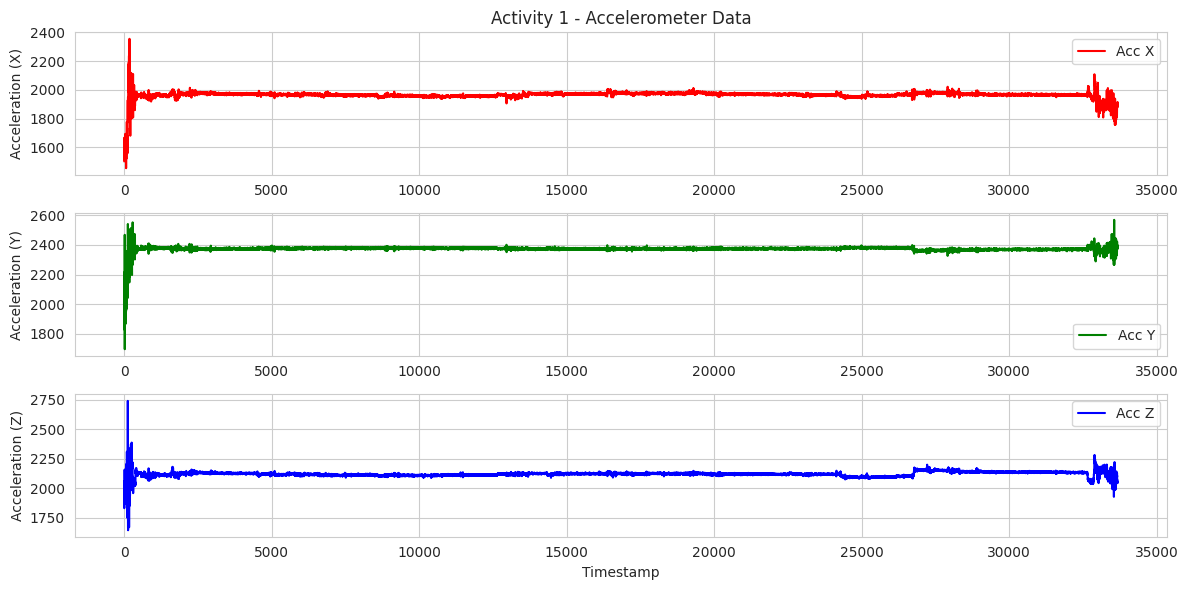

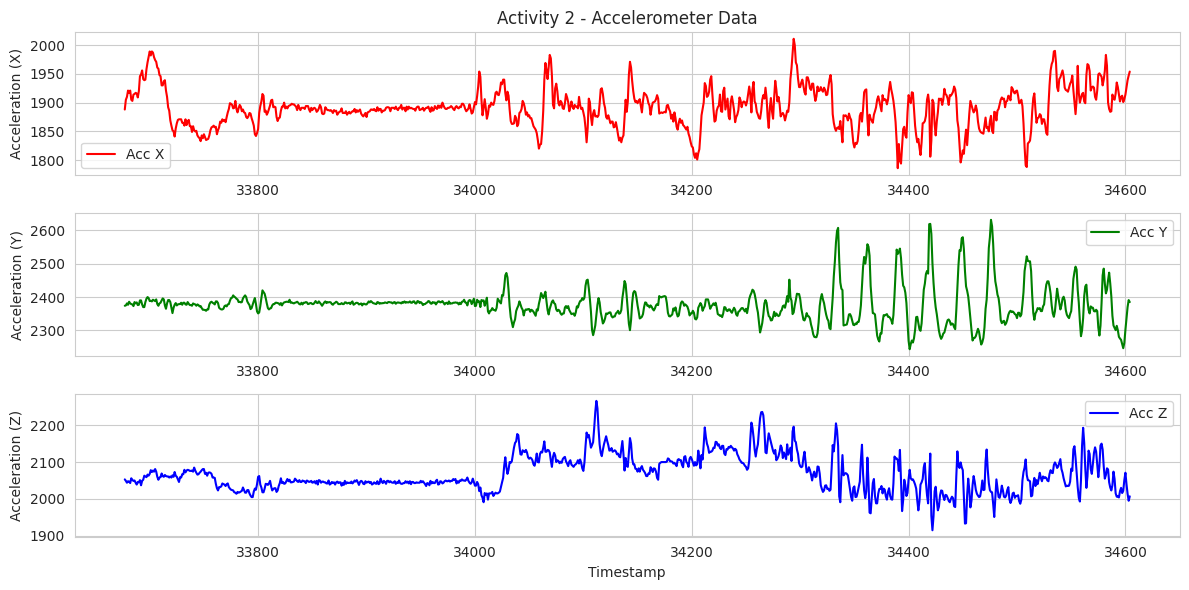

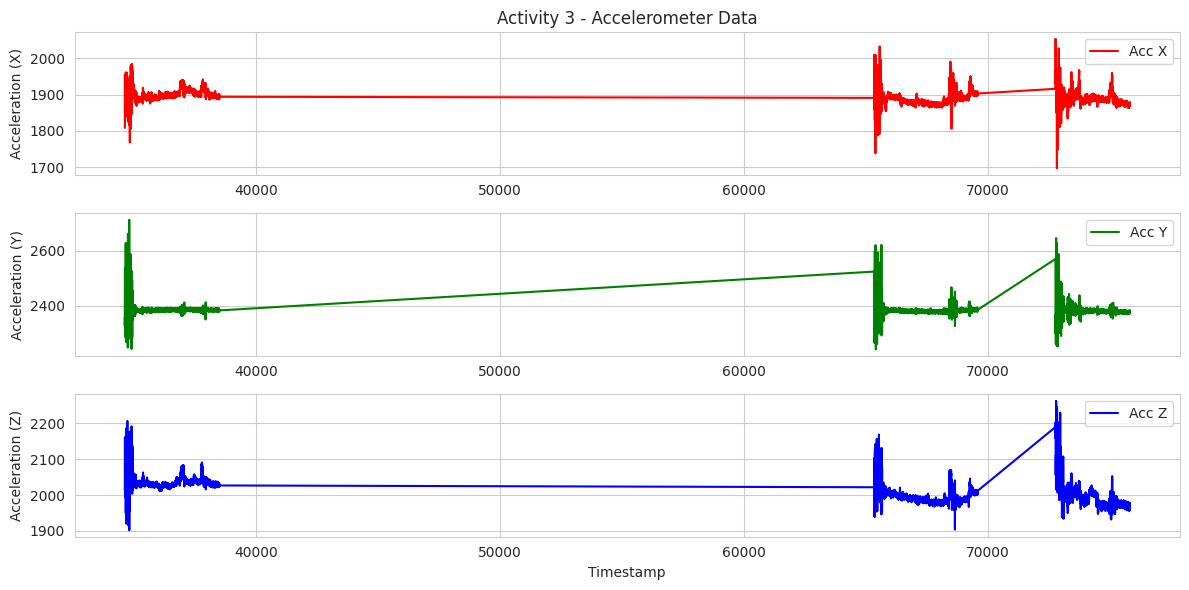

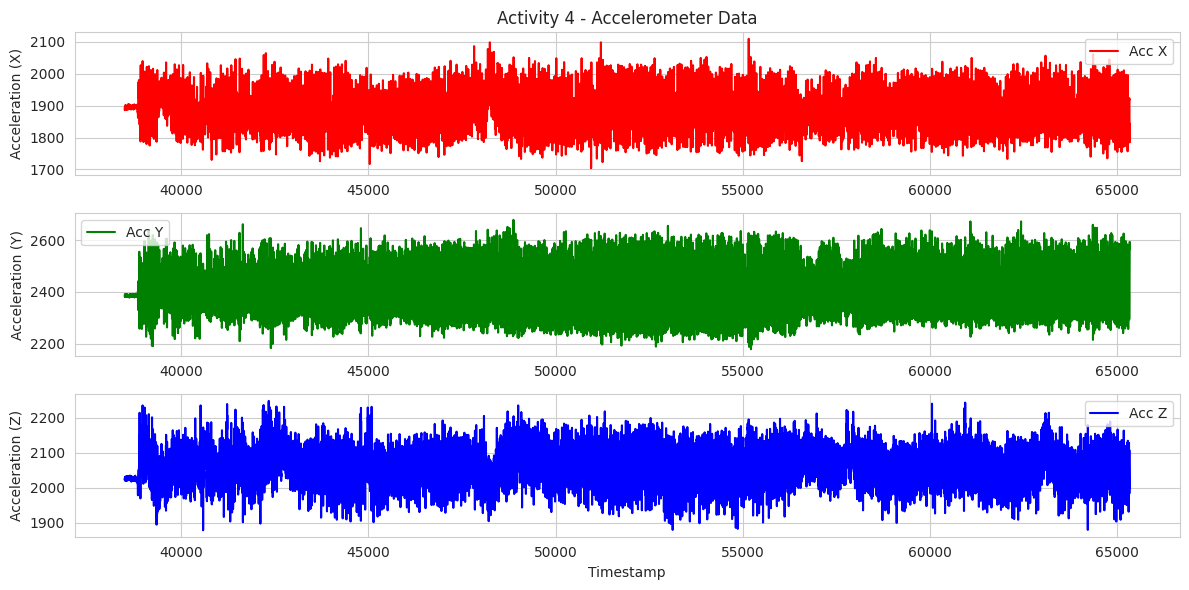

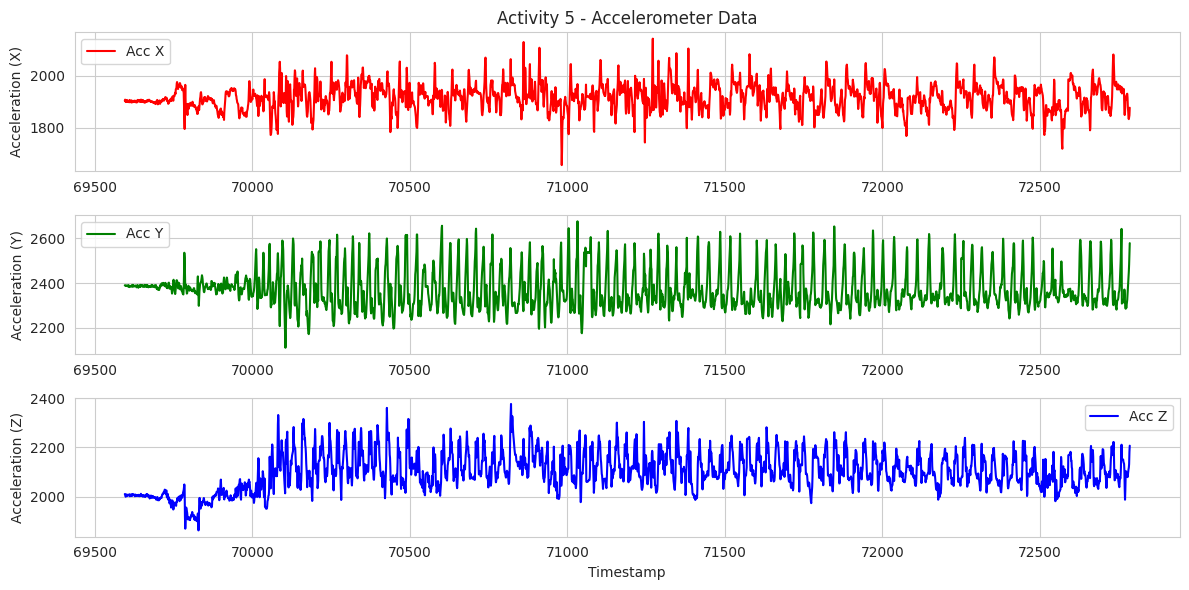

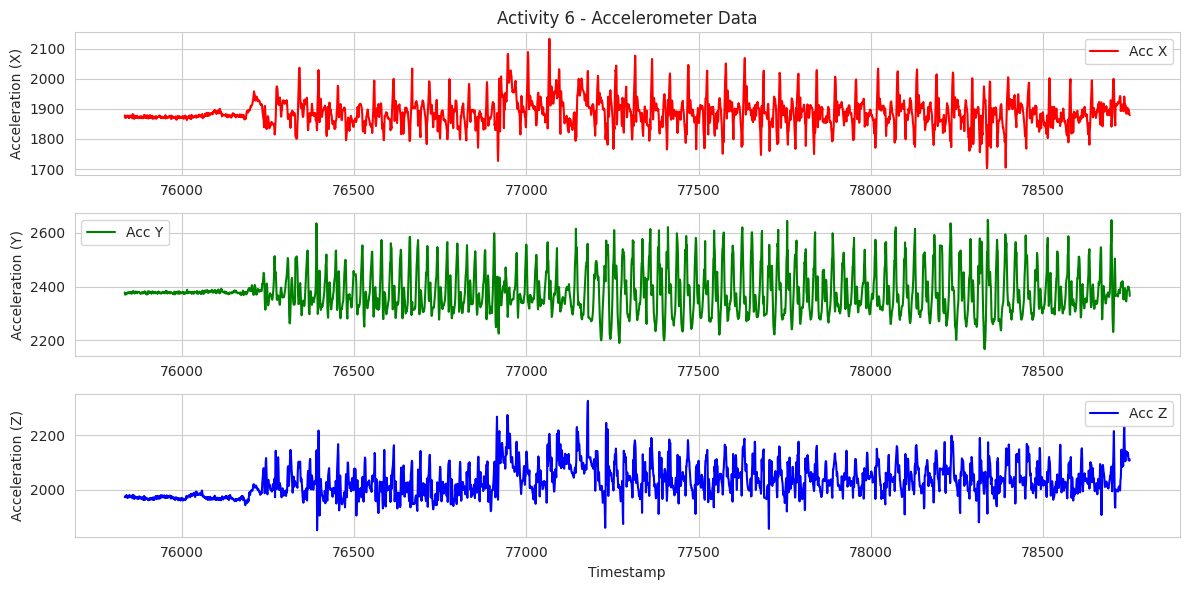

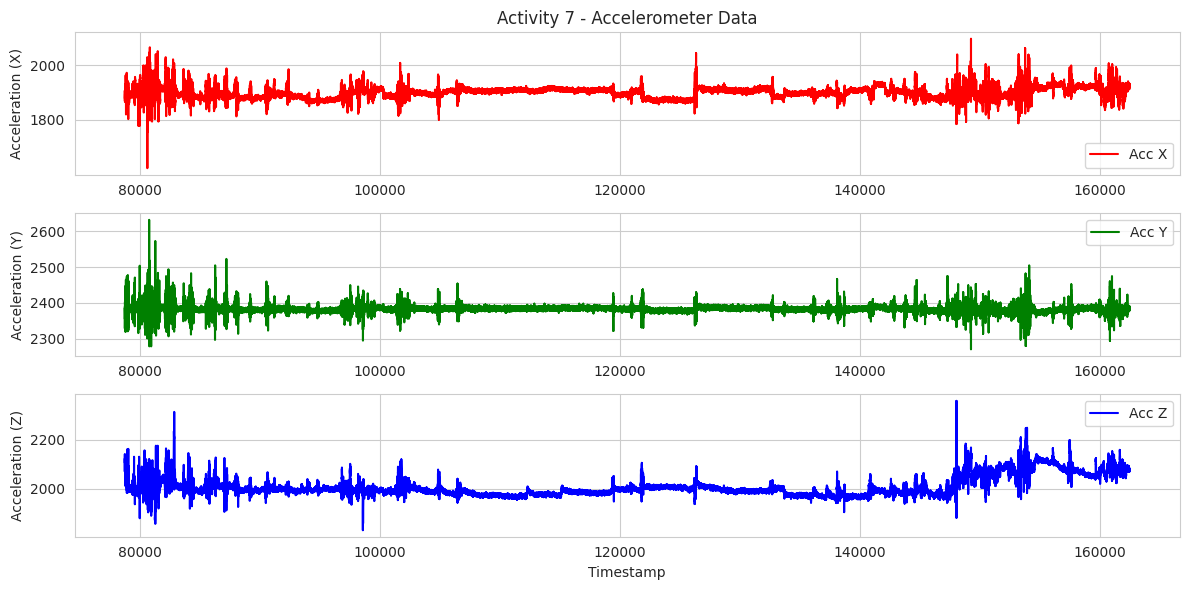

In [14]:
# Define a fixed time window
#time_window = 800  # Number of samples to visualize per activity

# Set plot style
sns.set_style("whitegrid")

# Create plots for each activity
for act in activities:
    plt.figure(figsize=(12, 6))

    # Extract data for the current activity
    #df_act = df[df["Activity"] == act].head(time_window)  # Select first `time_window` samples
    df_act = df[df["Activity"] == act]

    # Plot acc_x
    plt.subplot(3, 1, 1)
    plt.plot(df_act["Timestamp"], df_act["acc_x"], color="r", label="Acc X")
    plt.title(f"Activity {act} - Accelerometer Data")
    plt.ylabel("Acceleration (X)")
    plt.legend()

    # Plot acc_y
    plt.subplot(3, 1, 2)
    plt.plot(df_act["Timestamp"], df_act["acc_y"], color="g", label="Acc Y")
    plt.ylabel("Acceleration (Y)")
    plt.legend()

    # Plot acc_z
    plt.subplot(3, 1, 3)
    plt.plot(df_act["Timestamp"], df_act["acc_z"], color="b", label="Acc Z")
    plt.xlabel("Timestamp")
    plt.ylabel("Acceleration (Z)")
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

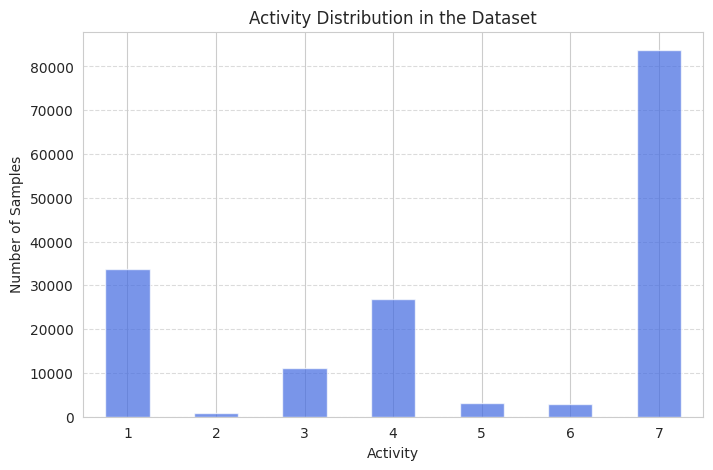

In [15]:
# --- Activity Distribution ---
plt.figure(figsize=(8, 5))
df["Activity"].value_counts().sort_index().plot(kind="bar", color="royalblue", alpha=0.7)
plt.xlabel("Activity")
plt.ylabel("Number of Samples")
plt.title("Activity Distribution in the Dataset")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [20]:
# ---  Statistical Summary per Activity ---
activity_groups = df.groupby("Activity")[["acc_x", "acc_y", "acc_z"]].describe()
activity_groups

acc_x                                                          \
            count         mean        std     min     25%     50%     75%   
Activity                                                                    
1         33677.0  1964.881878  27.693189  1455.0  1961.0  1968.0  1973.0   
2           928.0  1891.502155  33.139729  1786.0  1874.0  1890.0  1909.0   
3         11179.0  1892.964129  19.478270  1697.0  1881.0  1891.0  1901.0   
4         26860.0  1884.366679  45.858063  1704.0  1858.0  1885.0  1908.0   
5          3191.0  1917.553745  49.773495  1656.0  1887.0  1918.0  1949.0   
6          2917.0  1887.882756  46.682375  1703.0  1864.0  1883.0  1910.0   
7         83748.0  1900.415043  20.401656  1624.0  1887.0  1902.0  1911.0   

                    acc_y               ...                    acc_z  \
             max    count         mean  ...     75%     max    count   
Activity                                ...                            
1         2356.0  33677.0  2373.065891  ...  2378.0  2569.0  33677.0   
2         2011.0    928.0  2376.728448  ...  2387.0  2631.0    928.0   
3         2054.0  11179.0  2383.224618  ...  2387.0  2713.0  11179.0   
4         2110.0  26860.0  2380.764743  ...  2433.0  2678.0  26860.0   
5         2143.0   3191.0  2374.069257  ...  2411.0  2677.0   3191.0   
6         2133.0   2917.0  2381.502571  ...  2416.0  2648.0   2917.0   
7         2096.0  83748.0  2382.878122  ...  2387.0  2632.0  83748.0   

                                                                           
                 mean        std     min      25%     50%     75%     max  
Activity                                                                   
1         2119.106868  23.344349  1644.0  2112.00  2120.0  2128.0  2739.0  
2         2067.889009  48.622886  1915.0  2039.75  2054.0  2100.0  2266.0  
3         2010.568477  32.865828  1902.0  1985.00  2006.0  2031.0  2263.0  
4         2051.305994  48.772676  1878.0  2018.00  2043.0  2084.0  2248.0  
5         2102.992165  75.163201  1862.0  2054.50  2097.0  2155.0  2377.0  
6         2032.737744  59.038450  1851.0  1987.00  2024.0  2070.0  2326.0  
7         2008.392344  39.449652  1830.0  1983.00  1996.0  2016.0  2358.0  

[7 rows x 24 columns]

<ipython-input-21-cc4096d33ba6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Activity", y=col, data=df, palette="coolwarm")
<ipython-input-21-cc4096d33ba6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Activity", y=col, data=df, palette="coolwarm")
<ipython-input-21-cc4096d33ba6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Activity", y=col, data=df, palette="coolwarm")


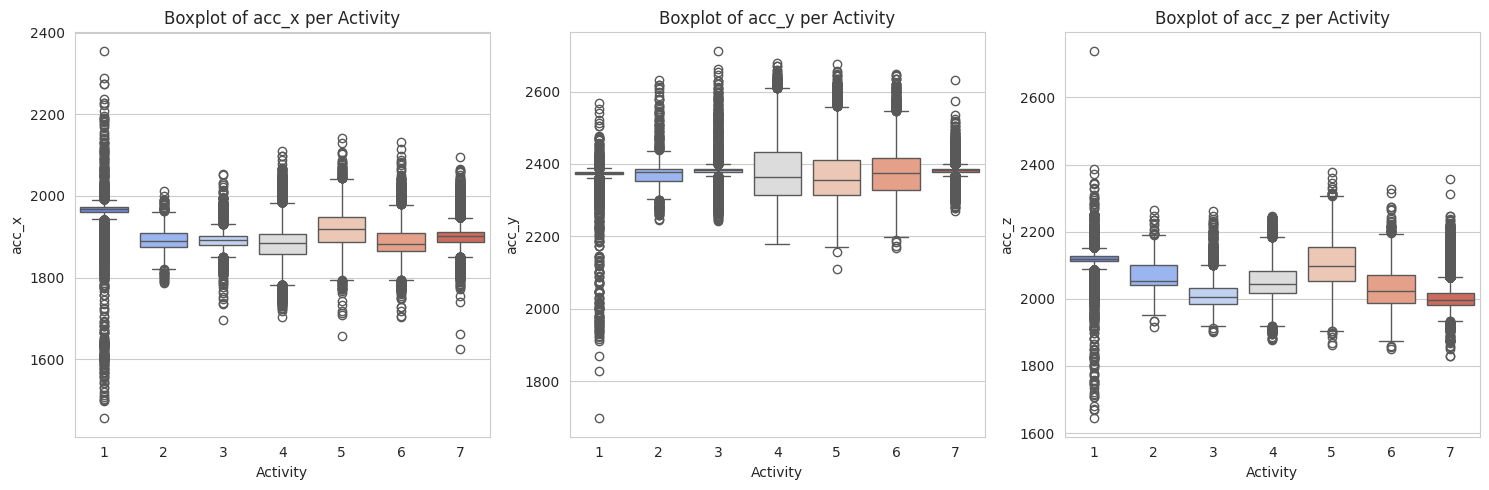

In [21]:
# --- Boxplots: Acceleration per Activity ---
plt.figure(figsize=(15, 5))
for i, col in enumerate(["acc_x", "acc_y", "acc_z"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="Activity", y=col, data=df, palette="coolwarm")
    plt.xlabel("Activity")
    plt.ylabel(col)
    plt.title(f"Boxplot of {col} per Activity")

plt.tight_layout()
plt.show()

<ipython-input-22-da714a6e879e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Activity", y=col, data=df, palette="coolwarm", inner="quartile")
<ipython-input-22-da714a6e879e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Activity", y=col, data=df, palette="coolwarm", inner="quartile")
<ipython-input-22-da714a6e879e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Activity", y=col, data=df, palette="coolwarm", inner="quartile")


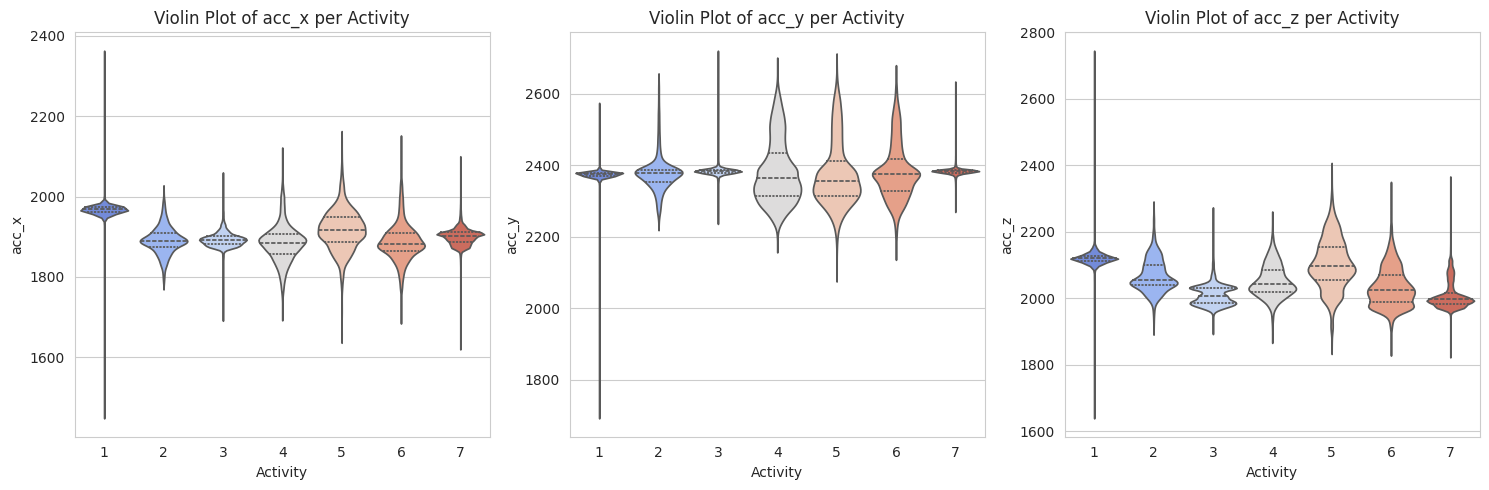

In [22]:
# Violin Plots: Acceleration Distribution per Activity ---
plt.figure(figsize=(15, 5))
for i, col in enumerate(["acc_x", "acc_y", "acc_z"], 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x="Activity", y=col, data=df, palette="coolwarm", inner="quartile")
    plt.xlabel("Activity")
    plt.ylabel(col)
    plt.title(f"Violin Plot of {col} per Activity")

plt.tight_layout()
plt.show()

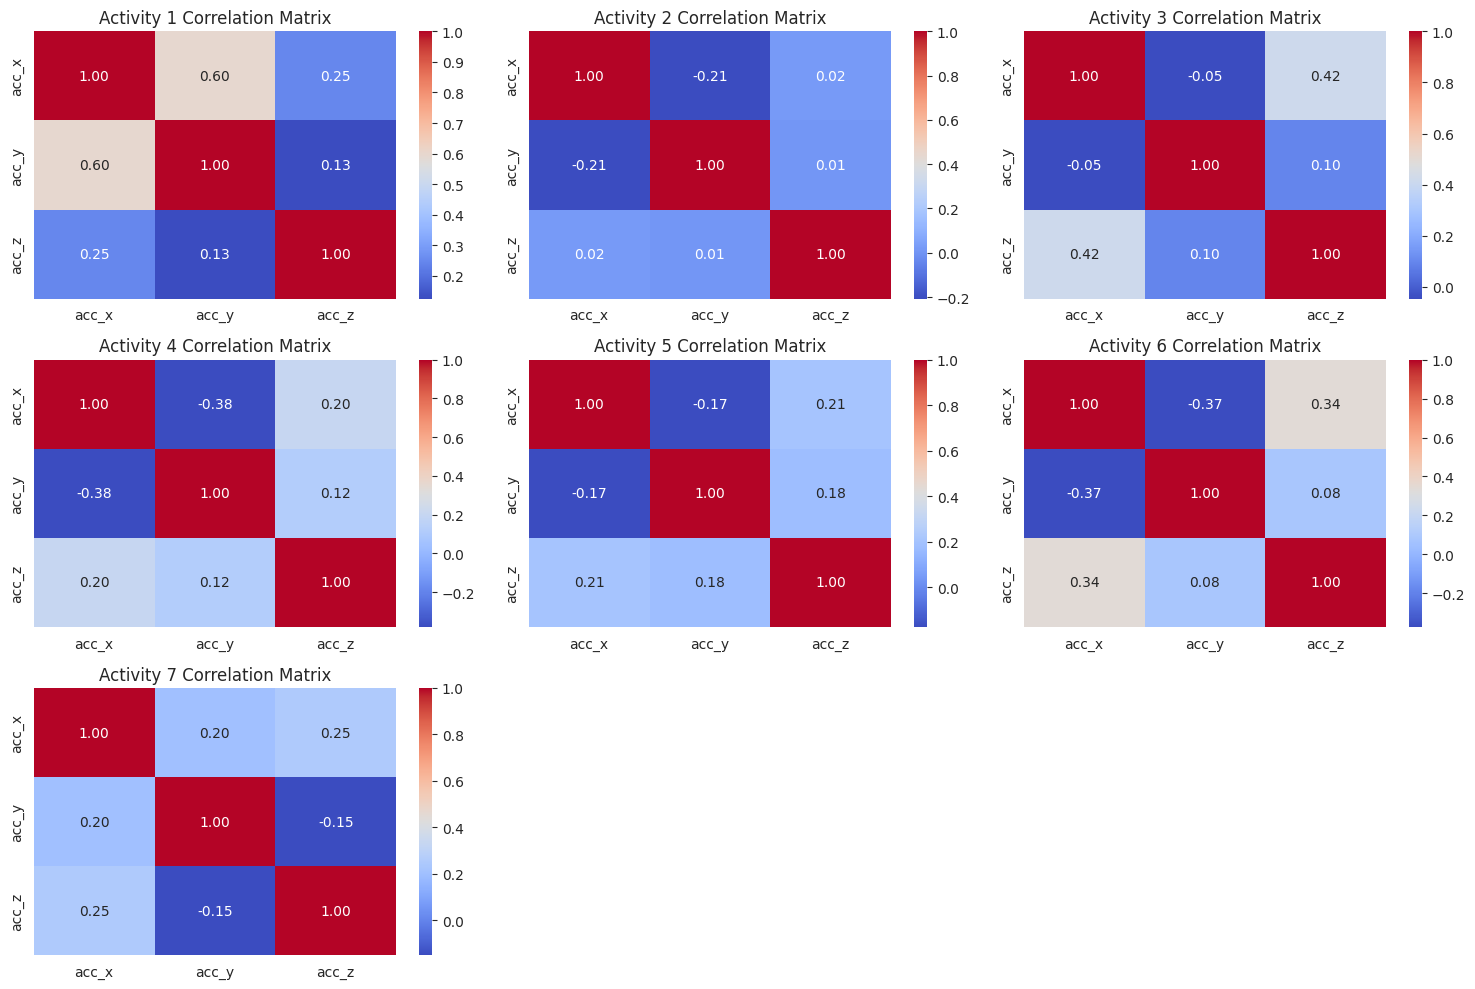

In [18]:
# --- Correlation Matrix per Activity ---
activities = df["Activity"].unique()

plt.figure(figsize=(15, 10))
for i, act in enumerate(activities, 1):
    plt.subplot(3, 3, i)
    corr_matrix = df[df["Activity"] == act][["acc_x", "acc_y", "acc_z"]].corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Activity {act} Correlation Matrix")

plt.tight_layout()
plt.show()

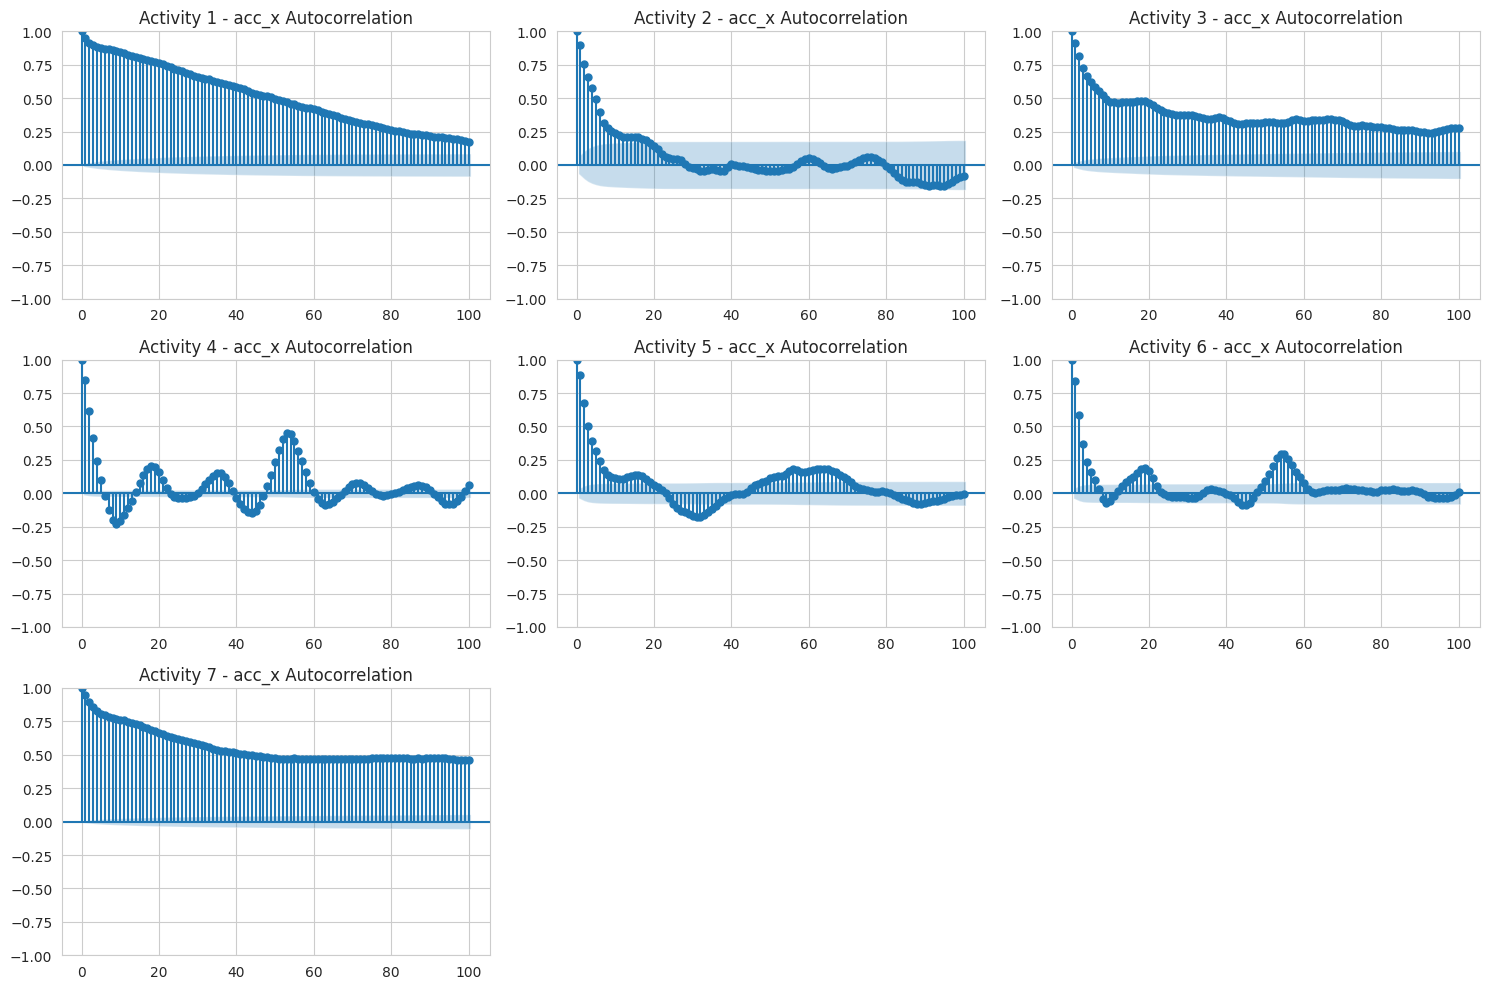

In [32]:
# --- Autocorrelation Function (ACF) per Activity ---
# --- Accelerometer x --- #
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(15, 10))
for i, act in enumerate(activities, 1):
    plt.subplot(3, 3, i)
    #signal = df[df["Activity"] == act]["acc_x"][:1000]  # Limiting to first 1000 samples
    signal = df[df["Activity"] == act]["acc_x"]
    plot_acf(signal, lags=100, title=f"Activity {act} - acc_x Autocorrelation", ax=plt.gca())

plt.tight_layout()
plt.show()

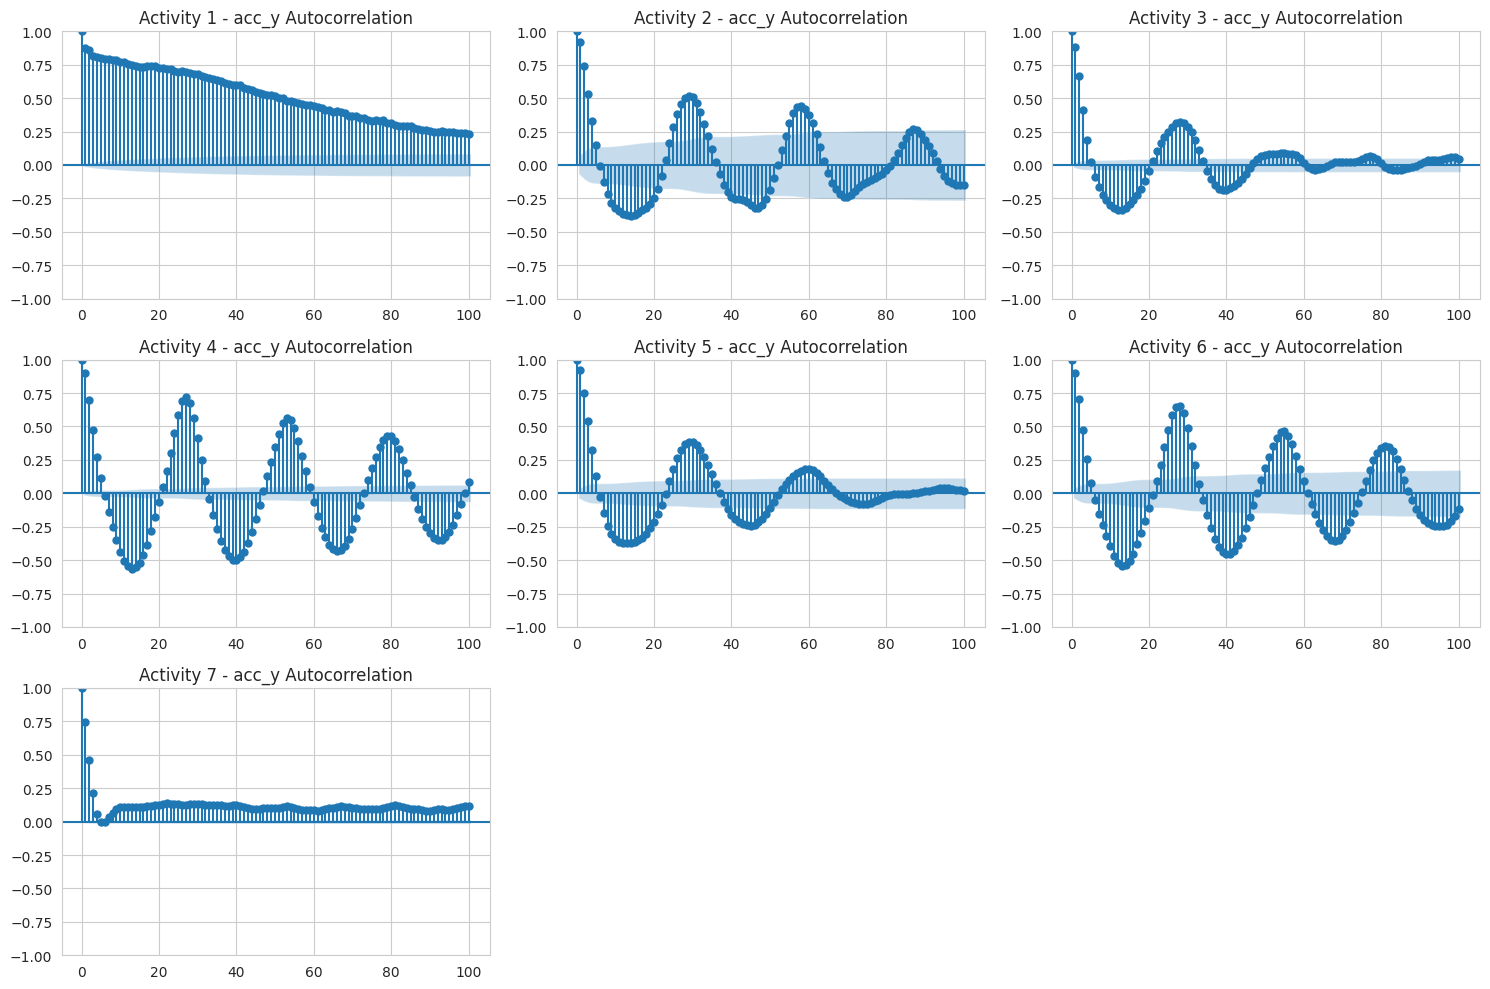

In [34]:
# --- Autocorrelation Function (ACF) per Activity ---
# --- Accelerometer y --- #
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(15, 10))
for i, act in enumerate(activities, 1):
    plt.subplot(3, 3, i)
    #signal = df[df["Activity"] == act]["acc_y"][:1000]  # Limiting to first 1000 samples
    signal = df[df["Activity"] == act]["acc_y"]
    plot_acf(signal, lags=100, title=f"Activity {act} - acc_y Autocorrelation", ax=plt.gca())

plt.tight_layout()
plt.show()

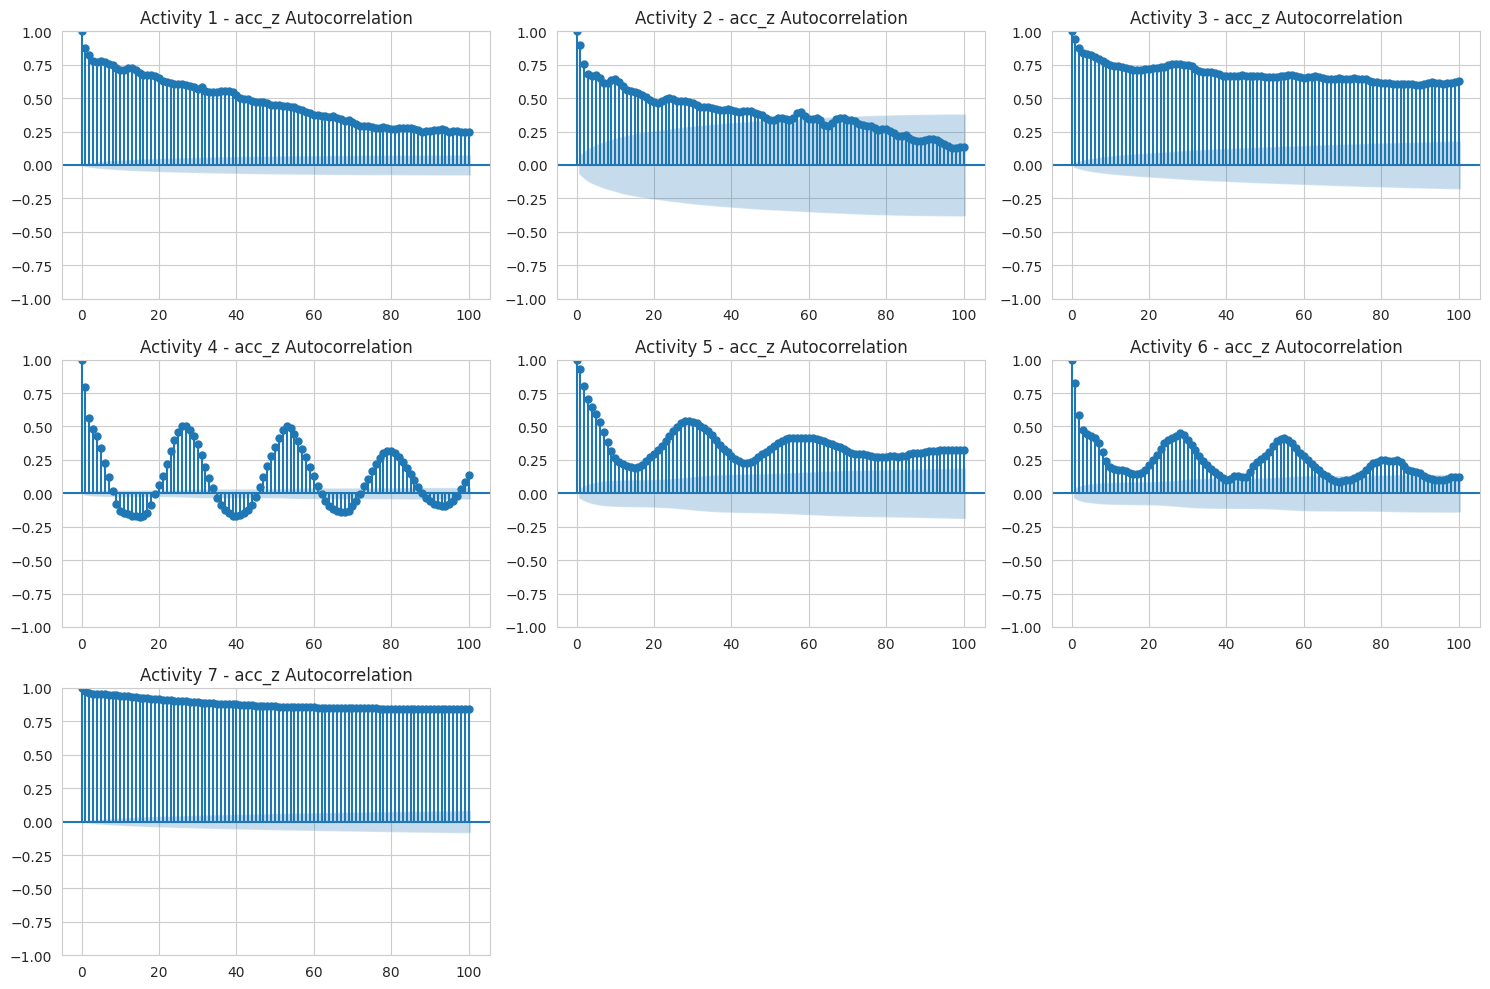

In [35]:
# --- Autocorrelation Function (ACF) per Activity ---
# --- Accelerometer z --- #
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(15, 10))
for i, act in enumerate(activities, 1):
    plt.subplot(3, 3, i)
    #signal = df[df["Activity"] == act]["acc_z"][:1000]  # Limiting to first 1000 samples
    signal = df[df["Activity"] == act]["acc_z"]
    plot_acf(signal, lags=100, title=f"Activity {act} - acc_z Autocorrelation", ax=plt.gca())

plt.tight_layout()
plt.show()

In [36]:
# check for Null Values
print(df.isnull().sum())

Timestamp    0
acc_x        0
acc_y        0
acc_z        0
Activity     0
dtype: int64


# Weak Stationarity

A time series is said to be **weakly stationary** (or **second-order stationary**) if the following conditions are met:

### 1. **Constant Mean**

The expected value (mean) of the series is constant over time. This means that for all time points \( t \):

$$
E[X_t] = \mu \quad \text{for all} \, t
$$

### 2. **Constant Variance**

The variance of the series is constant over time. This means that for all time points \( t \):

$$
\text{Var}(X_t) = \sigma^2 \quad \text{for all} \, t
$$

### 3. **Covariance Depends on Lag**

The covariance between values at different times depends only on the time lag between them, not the actual time points. This means:

$$
\text{Cov}(X_t, X_{t+h}) = \gamma(h) \quad \text{for all} \, t \, \text{and} \, h
$$


### Conclusion:

Weak stationarity is often sufficient for many statistical methods, particularly those involving linear models.




## Augmented Dickey-Fuller (ADF) Test
The ADF test checks if a time series has a unit root (which indicates non-stationarity):

*   Null hypothesis (H<sub>0​</sub>): The series is non-stationary.
*   Alternative hypothesis (H​<sub>1​</sub>): The series is stationary.



*    If the p-value < 0.05, we reject H<sub>0​</sub> and conclude the series is stationary.
*    If the p-value ≥ 0.05, we fail to reject H<sub>0​</sub>  and the series is likely non-stationary.




In [37]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, series_name):
    result = adfuller(series, autolag="AIC")
    p_value = result[1]  # Get p-value
    print(f"ADF Test for {series_name}: p-value = {p_value:.5f}")

    if p_value < 0.05:
        print(f"✅ {series_name} is likely **stationary**.")
    else:
        print(f"❌ {series_name} is likely **non-stationary**.")

In [38]:
for act in activities:
  df_act = df[df["Activity"] == act]
  check_stationarity(df_act["acc_x"], f"Acceleration X, Activity:{act}")
  check_stationarity(df_act["acc_y"], f"Acceleration Y, Activity:{act}")
  check_stationarity(df_act["acc_z"], f"Acceleration Y, Activity:{act}")


ADF Test for Acceleration X, Activity:1: p-value = 0.00000
✅ Acceleration X, Activity:1 is likely **stationary**.
ADF Test for Acceleration Y, Activity:1: p-value = 0.00000
✅ Acceleration Y, Activity:1 is likely **stationary**.
ADF Test for Acceleration Y, Activity:1: p-value = 0.00000
✅ Acceleration Y, Activity:1 is likely **stationary**.
ADF Test for Acceleration X, Activity:2: p-value = 0.00000
✅ Acceleration X, Activity:2 is likely **stationary**.
ADF Test for Acceleration Y, Activity:2: p-value = 0.00000
✅ Acceleration Y, Activity:2 is likely **stationary**.
ADF Test for Acceleration Y, Activity:2: p-value = 0.01547
✅ Acceleration Y, Activity:2 is likely **stationary**.
ADF Test for Acceleration X, Activity:3: p-value = 0.00000
✅ Acceleration X, Activity:3 is likely **stationary**.
ADF Test for Acceleration Y, Activity:3: p-value = 0.00000
✅ Acceleration Y, Activity:3 is likely **stationary**.
ADF Test for Acceleration Y, Activity:3: p-value = 0.00018
✅ Acceleration Y, Activity:3 

## Rolling Statistics (Mean & Variance)

A weakly stationary time series should have constant mean over time  and constant variance over time.

We can plot the rolling mean & variance to visually assess stationarity.

In [39]:
def plot_rolling_statistics(series, series_name, window=50):
    plt.figure(figsize=(10, 4))

    # Compute rolling statistics
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    # Plot original series
    plt.plot(series, color="blue", alpha=0.5, label="Original")

    # Plot rolling mean & variance
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="green", label="Rolling Std Dev")

    plt.title(f"Rolling Mean & Variance - {series_name}")
    plt.legend()
    plt.show()

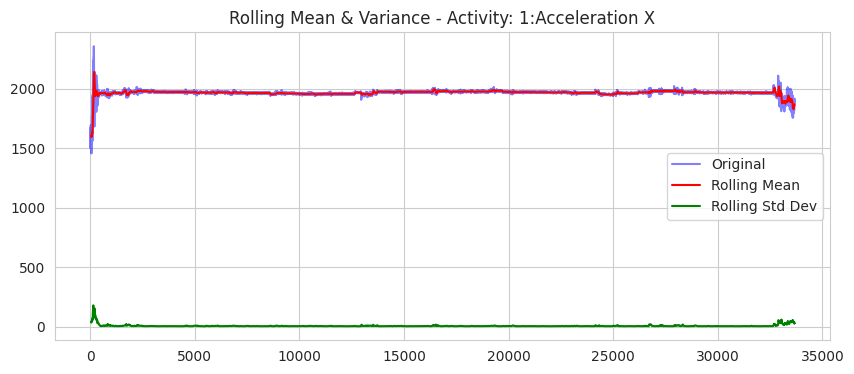

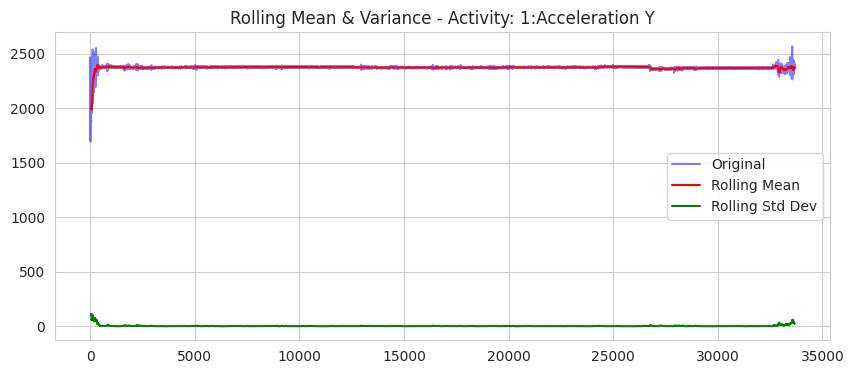

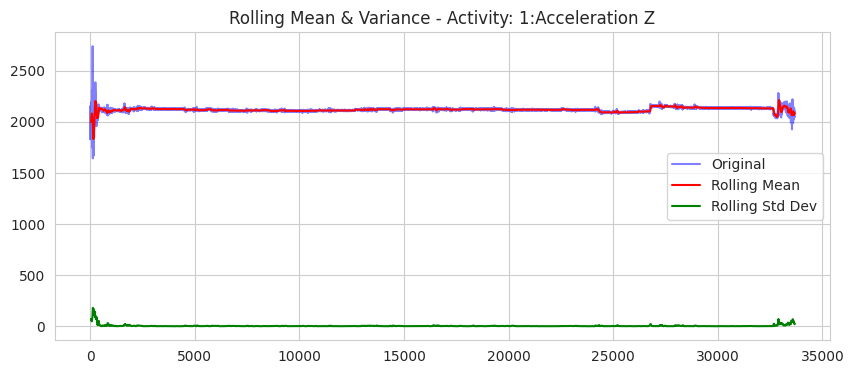

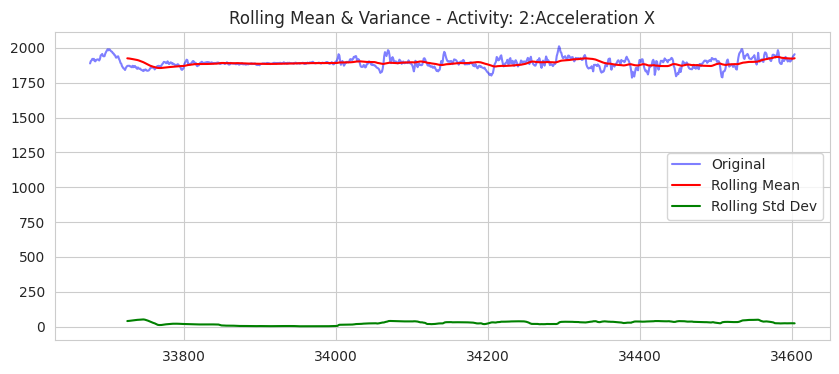

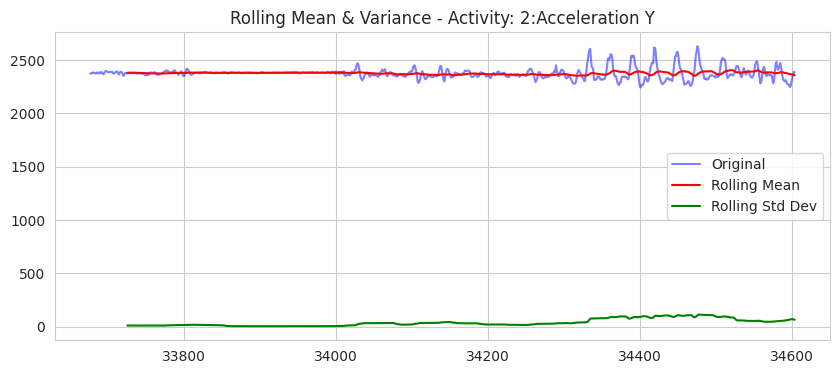

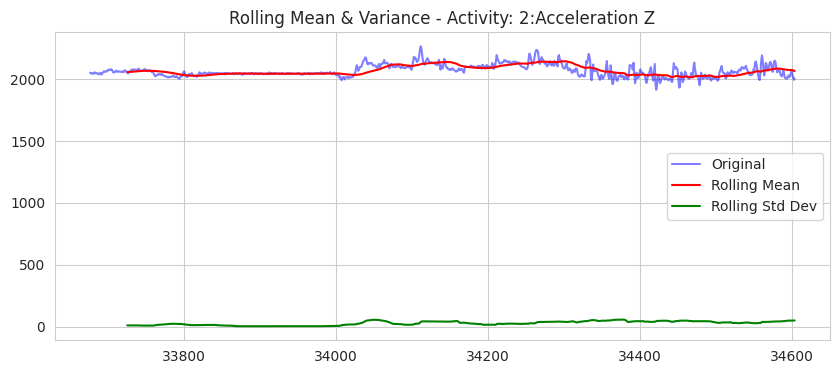

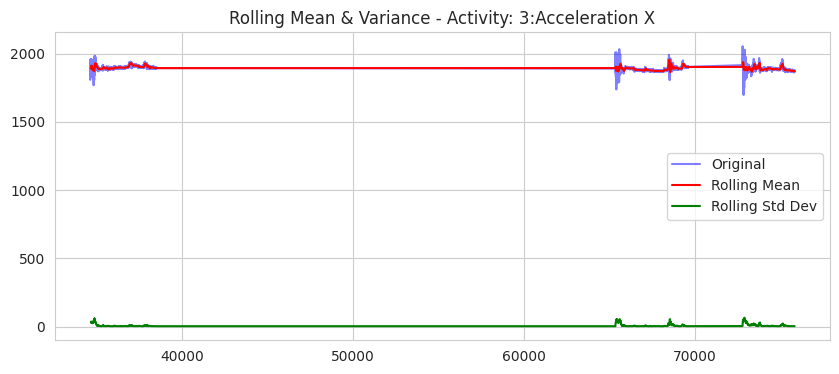

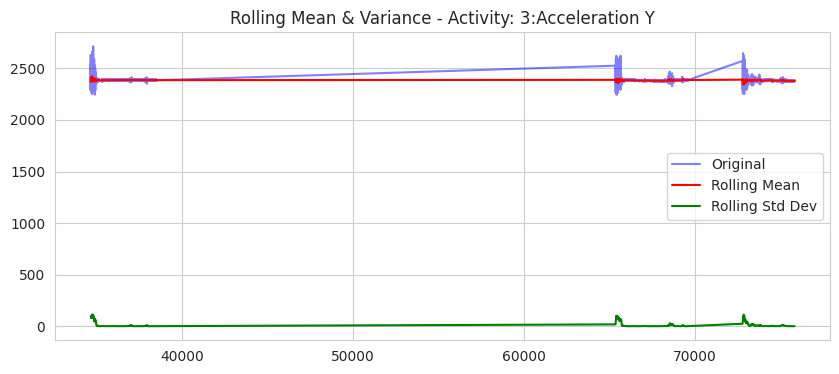

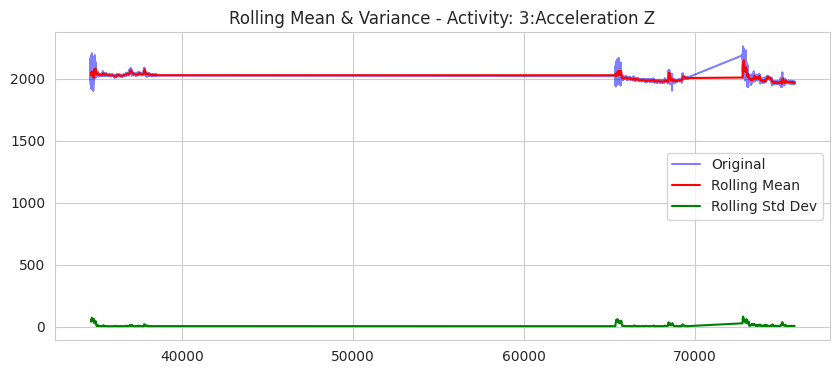

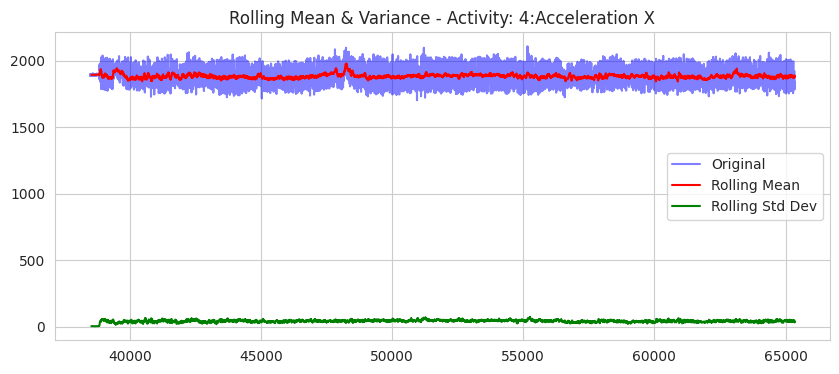

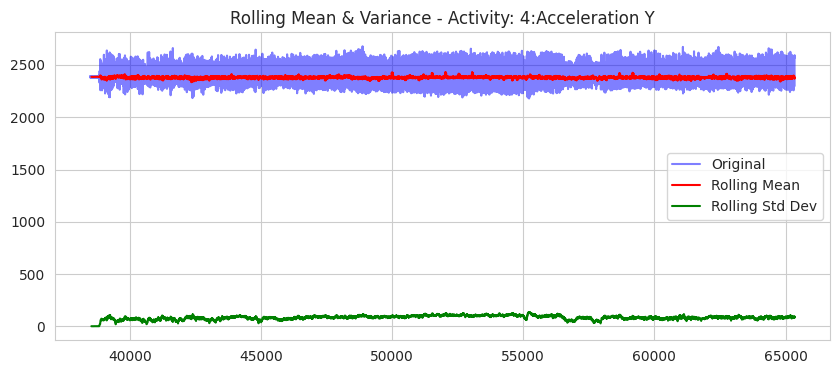

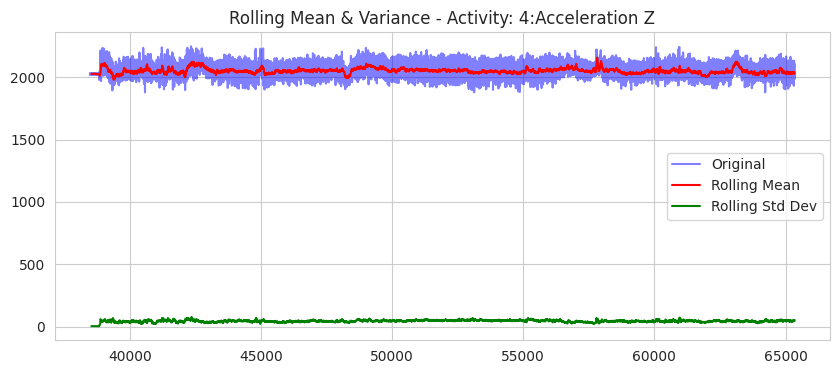

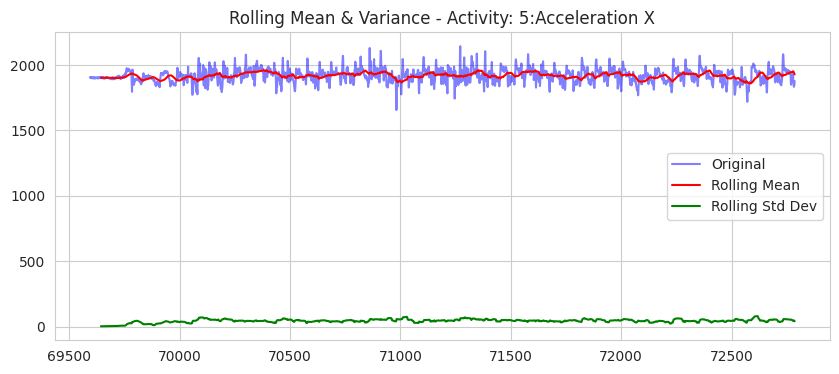

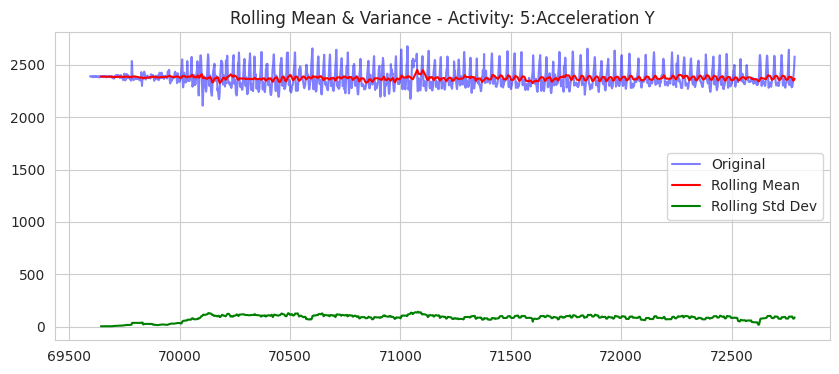

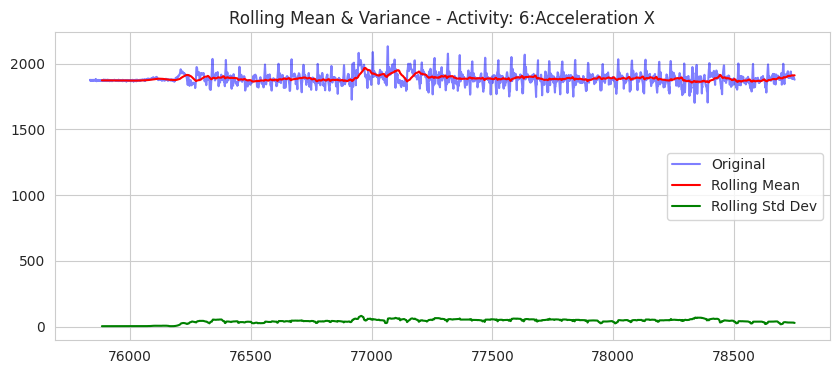

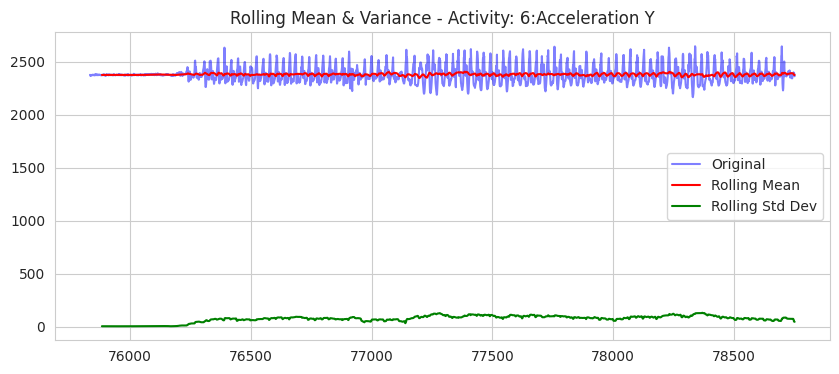

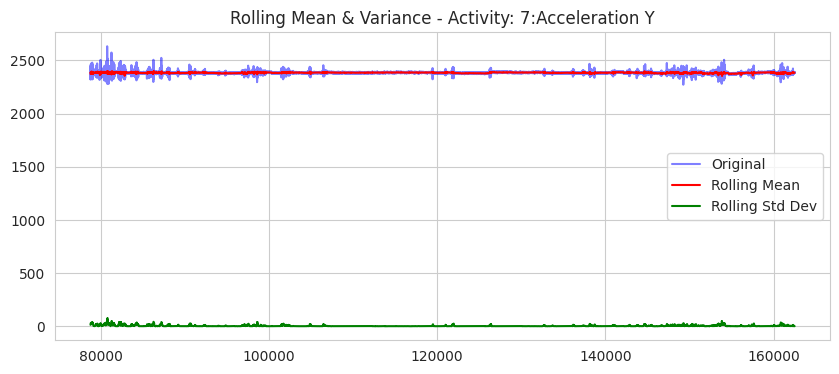

In [40]:
for act in activities:
  df_act = df[df["Activity"] == act]
  # Apply to each accelerometer axis
  plot_rolling_statistics(df_act["acc_x"], f"Activity: {act}:Acceleration X")
  plot_rolling_statistics(df_act["acc_y"], f"Activity: {act}:Acceleration Y")
  plot_rolling_statistics(df_act["acc_z"], f"Activity: {act}:Acceleration Z")

## Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

The KPSS test is another stationarity test, but it works opposite to ADF:
- Null hypothesis (H<sub>0</sub>​): The series is stationary.
- Alternative hypothesis (H<sub>1</sub>​): The series is non-stationary.


In [41]:
from statsmodels.tsa.stattools import kpss

def check_kpss(series, series_name):
    result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
    p_value = result[1]
    print(f"KPSS Test for {series_name}: p-value = {p_value:.5f}")

    if p_value < 0.05:
        print(f"❌ {series_name} is likely **non-stationary**.")
    else:
        print(f"✅ {series_name} is likely **stationary**.")

In [43]:
for act in activities:
  df_act = df[df["Activity"] == act]
  check_kpss(df_act["acc_x"], f"Acceleration X, Activity:{act}")
  check_kpss(df_act["acc_y"], f"Acceleration Y, Activity:{act}")
  check_kpss(df_act["acc_z"], f"Acceleration Y, Activity:{act}")

KPSS Test for Acceleration X, Activity:1: p-value = 0.01000
❌ Acceleration X, Activity:1 is likely **non-stationary**.
KPSS Test for Acceleration Y, Activity:1: p-value = 0.01370
❌ Acceleration Y, Activity:1 is likely **non-stationary**.
KPSS Test for Acceleration Y, Activity:1: p-value = 0.01000
❌ Acceleration Y, Activity:1 is likely **non-stationary**.
KPSS Test for Acceleration X, Activity:2: p-value = 0.10000
✅ Acceleration X, Activity:2 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:2: p-value = 0.10000
✅ Acceleration Y, Activity:2 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:2: p-value = 0.03557
❌ Acceleration Y, Activity:2 is likely **non-stationary**.
KPSS Test for Acceleration X, Activity:3: p-value = 0.01000
❌ Acceleration X, Activity:3 is likely **non-stationary**.
KPSS Test for Acceleration Y, Activity:3: p-value = 0.01000
❌ Acceleration Y, Activity:3 is likely **non-stationary**.
KPSS Test for Acceleration Y, Activity:3: p-value = 0.01

<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-

## Differencing (First or Second Differences)
Differencing is one of the most commonly used techniques to make a time series stationary, especially when there is a trend component in the data.
By subtracting the previous value from the current value, you can remove the trend.

In [45]:
# Example: first difference to remove trends
df['acc_x_diff'] = df['acc_x'] - df['acc_x'].shift(1)
df['acc_x_diff'].dropna(inplace=True)
df['acc_y_diff'] = df['acc_y'] - df['acc_y'].shift(1)
df['acc_y_diff'].dropna(inplace=True)
df['acc_z_diff'] = df['acc_z'] - df['acc_z'].shift(1)
df['acc_z_diff'].dropna(inplace=True)

In [46]:
for act in activities:
  df_act = df[df["Activity"] == act]
  check_kpss(df_act["acc_x_diff"], f"Acceleration X, Activity:{act}")
  check_kpss(df_act["acc_y_diff"], f"Acceleration Y, Activity:{act}")
  check_kpss(df_act["acc_z_diff"], f"Acceleration Y, Activity:{act}")

KPSS Test for Acceleration X, Activity:1: p-value = nan
✅ Acceleration X, Activity:1 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:1: p-value = nan
✅ Acceleration Y, Activity:1 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:1: p-value = nan
✅ Acceleration Y, Activity:1 is likely **stationary**.
KPSS Test for Acceleration X, Activity:2: p-value = 0.10000
✅ Acceleration X, Activity:2 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:2: p-value = 0.10000
✅ Acceleration Y, Activity:2 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:2: p-value = 0.10000
✅ Acceleration Y, Activity:2 is likely **stationary**.
KPSS Test for Acceleration X, Activity:3: p-value = 0.10000
✅ Acceleration X, Activity:3 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:3: p-value = 0.10000
✅ Acceleration Y, Activity:3 is likely **stationary**.
KPSS Test for Acceleration Y, Activity:3: p-value = 0.10000
✅ Acceleration Y, Activity:3 is 

<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="c", nlags="legacy") # nlags legacy or auto
<ipython-input-41-7bf8e0a22761>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-

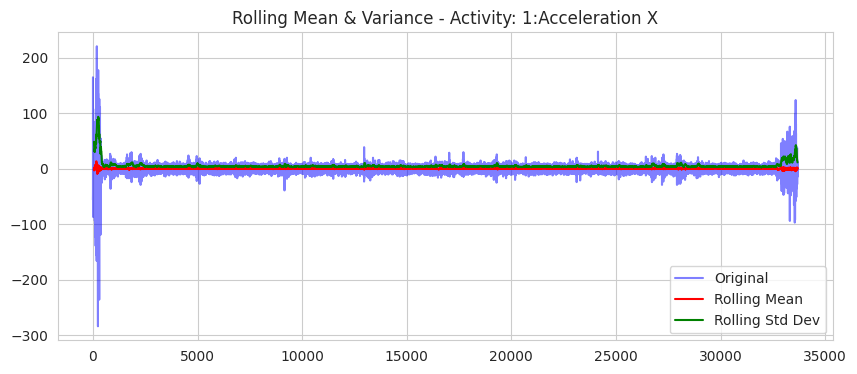

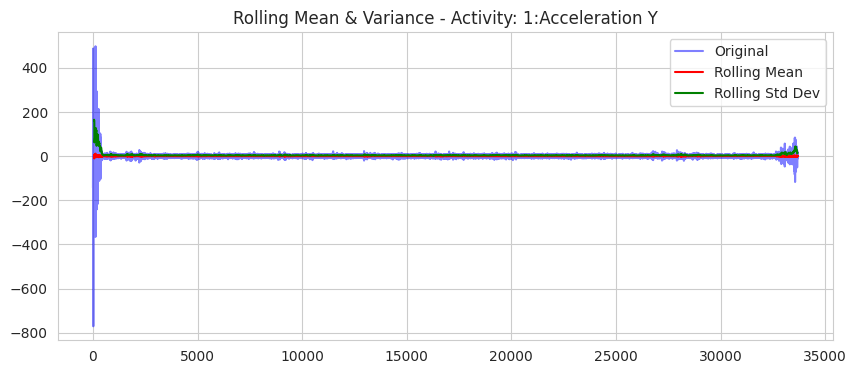

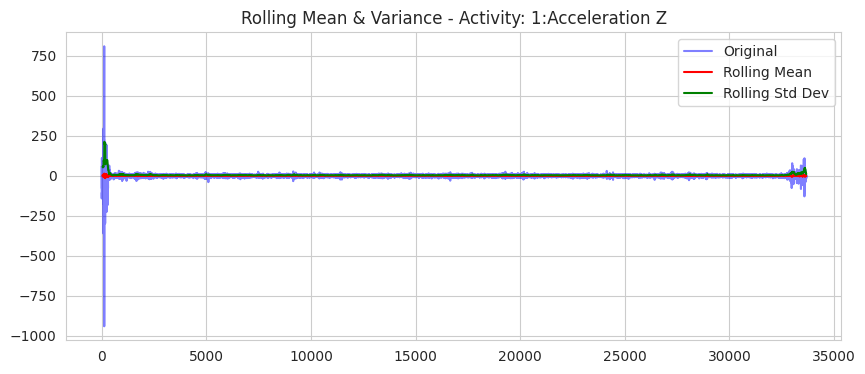

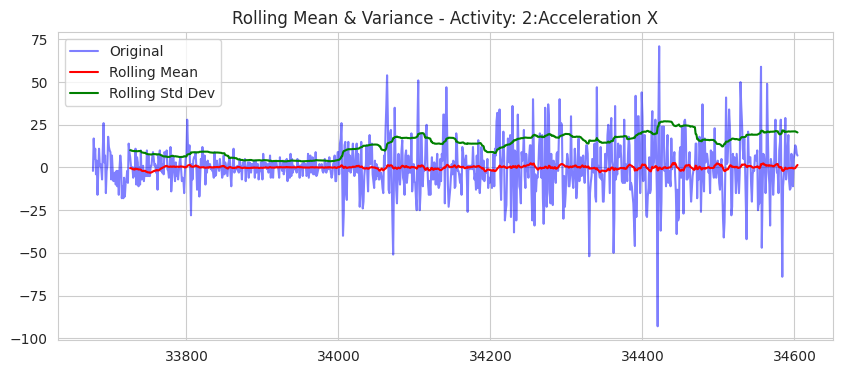

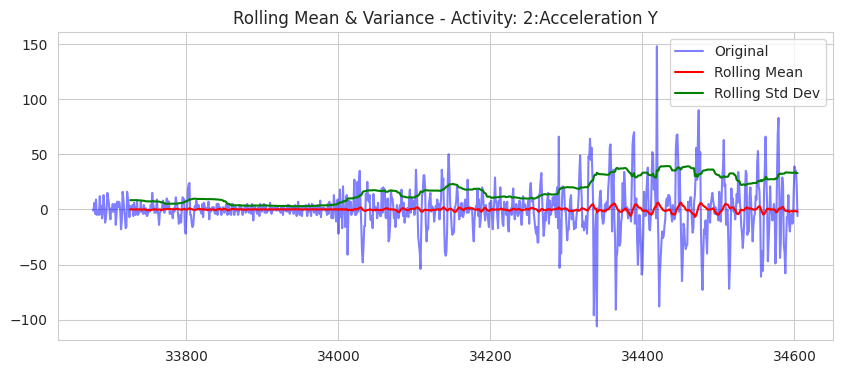

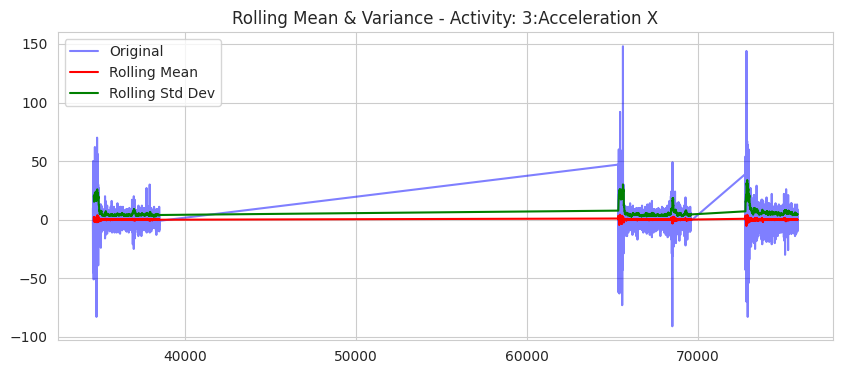

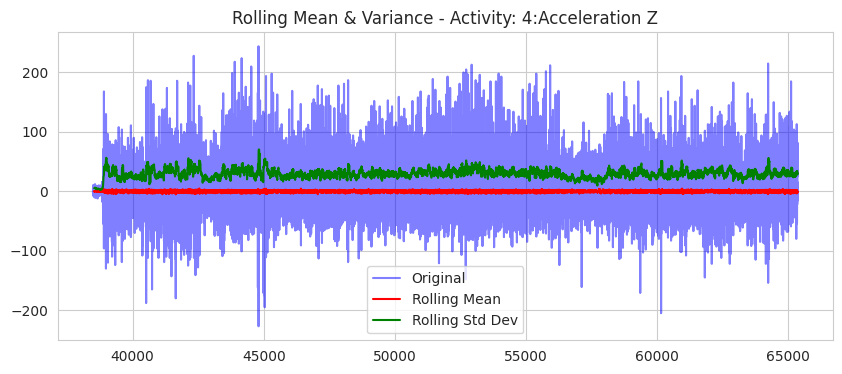

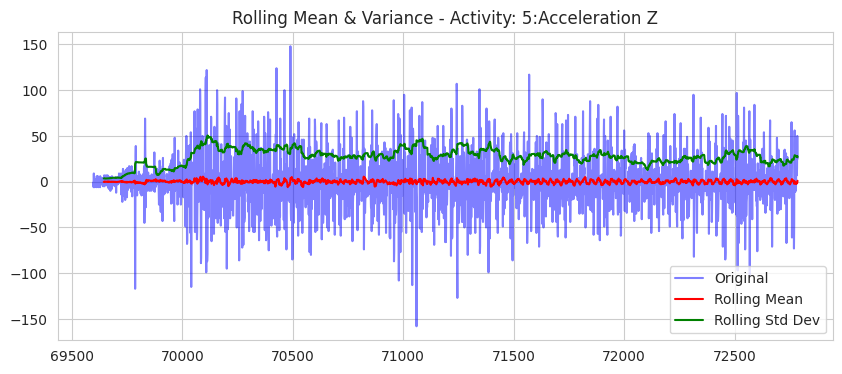

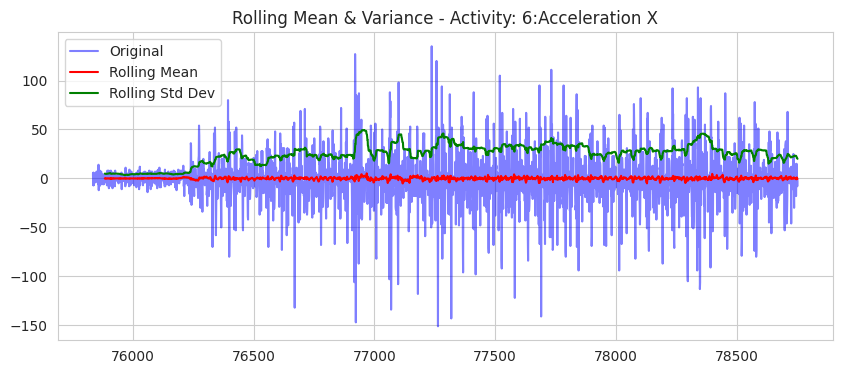

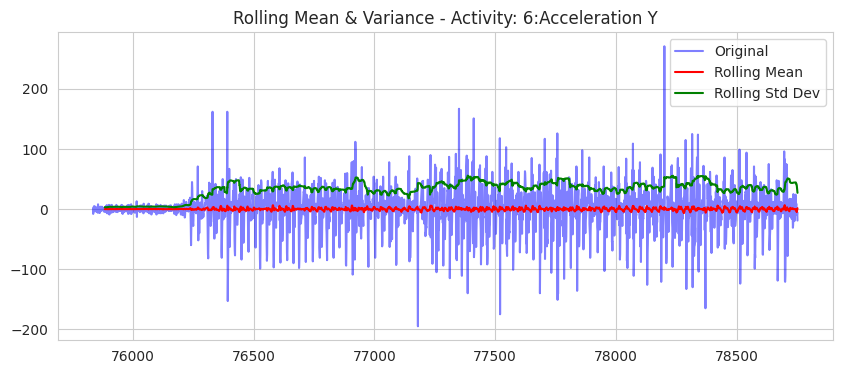

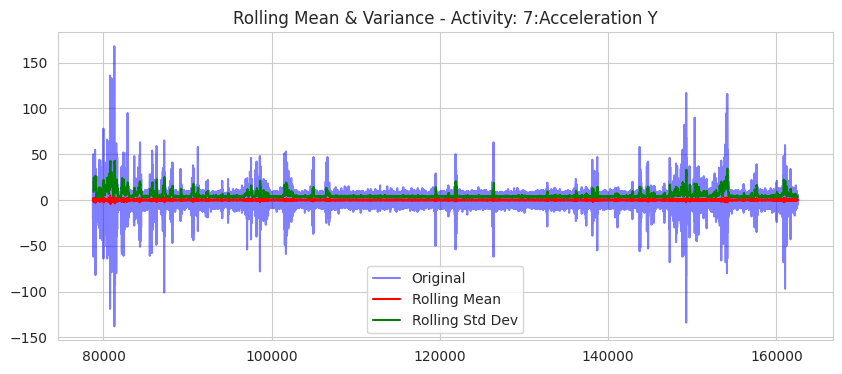

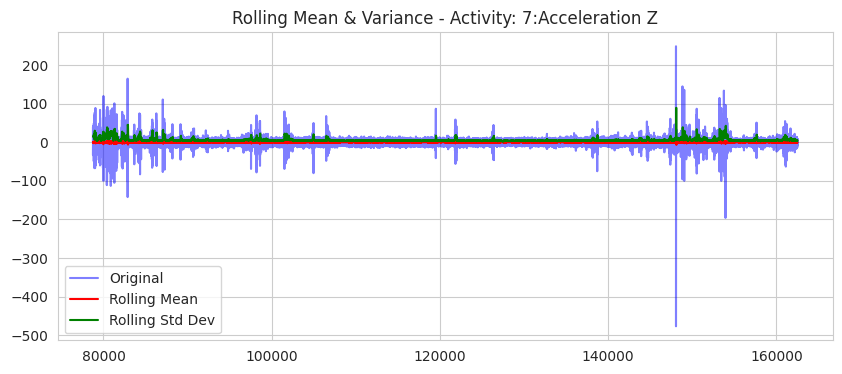

In [47]:
for act in activities:
  df_act = df[df["Activity"] == act]
  # Apply to each accelerometer axis
  plot_rolling_statistics(df_act["acc_x_diff"], f"Activity: {act}:Acceleration X")
  plot_rolling_statistics(df_act["acc_y_diff"], f"Activity: {act}:Acceleration Y")
  plot_rolling_statistics(df_act["acc_z_diff"], f"Activity: {act}:Acceleration Z")


# Introduction to CWT
> In simple terms, the Continuous Wavelet Transform is an analysis tool similar to the Fourier Transform, in that it takes a time-domain signal and returns the signal’s components in the frequency domain. However, in contrast to the Fourier Transform, the Continuous Wavelet Transform returns a two-dimensional result, providing information in the frequency- as well as in time-domain. Therefore, it is useful for periodic signals which change over time, such as audio, seismic signals and many others (see below for examples).

[pywavelets documentation](https://pywavelets.readthedocs.io/en/latest/ref/cwt.html)

The *cwt* Function --> main function, which calculates the CWR of a one-dim signal.

pywt.cwt(data, scales, wavelet): One dim Continuous Wavelet Transform.
Params:

*   **data**: *array_like*, input signal;
*   **scales**: *array_like*, The wavelet scales to use. One can use `f = scale2frequency(wavelet, scale)/sampling_period` to determine what physical frequency, `f`. Here, `f` is in hertz when the `sampling_period` is given in seconds;
*   **wavelet**: Wavelet object or name of the wavelet to use

Returns:
*   coefs: *array_like*. Continuous wavelet transform of the input signal for the given scales and wavelet. The first axis of `coefs` corresponds to the scales. The remaining axes match the shape of `data`.
*   frequencies: *array_like*. If the unit of sampling period are seconds and given, then frequencies are in hertz. Otherwise, a sampling period of 1 is assumed.

Note: size of coefficients array depends on the length of the inout array and the length of the given scales





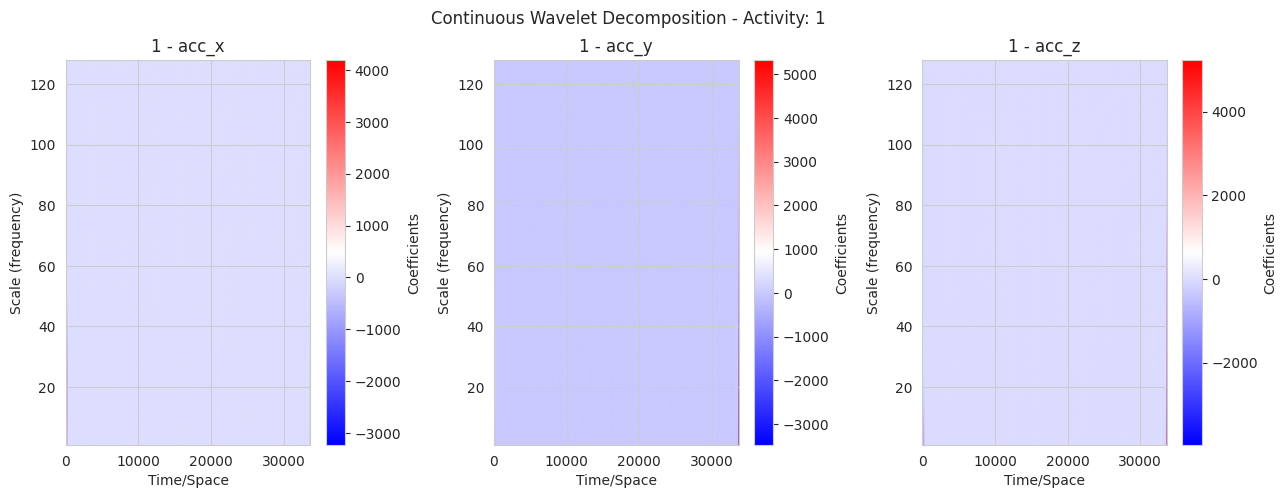

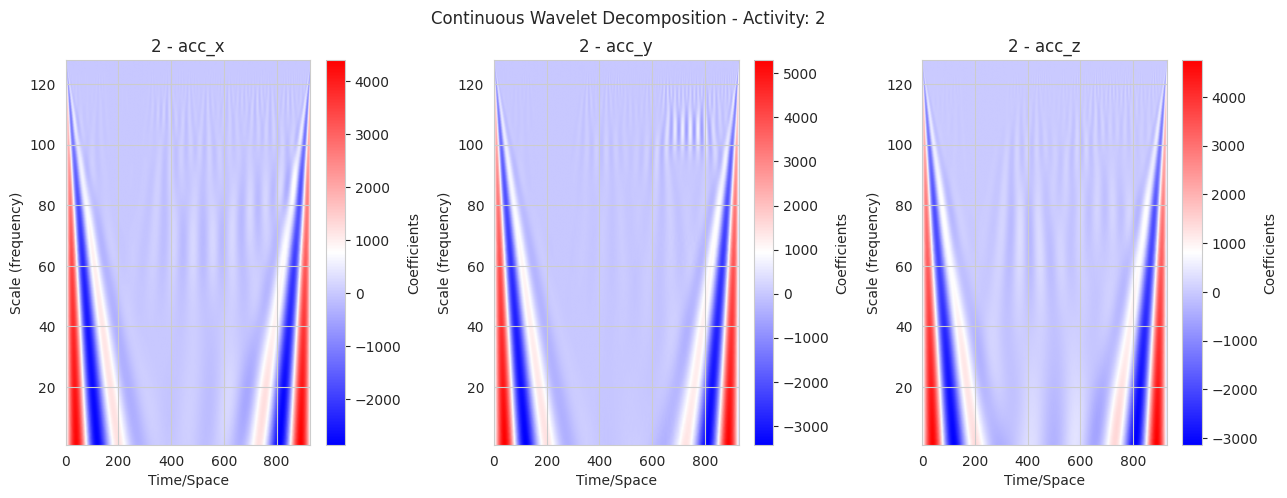

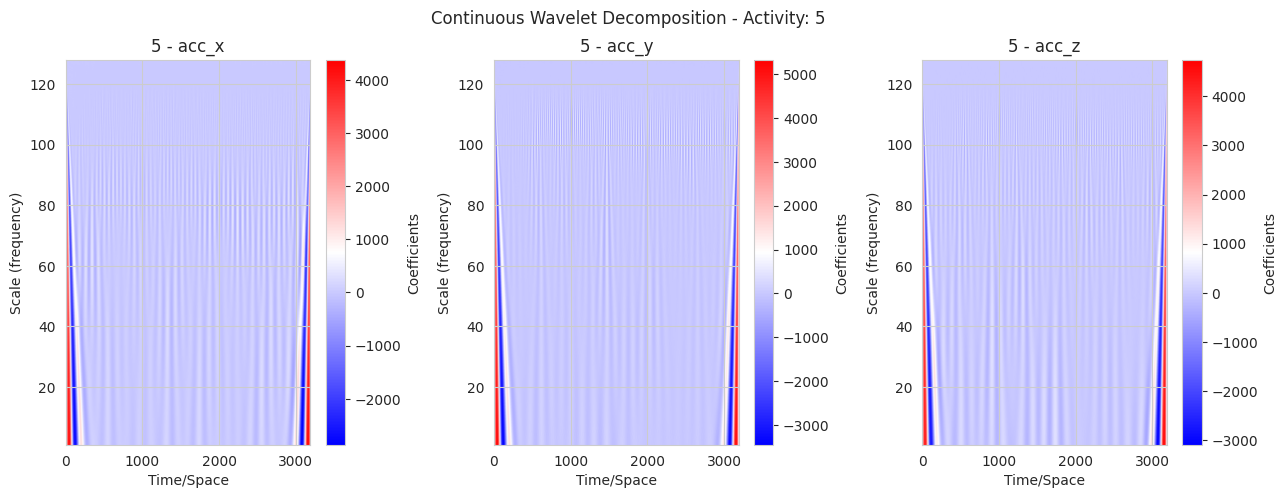

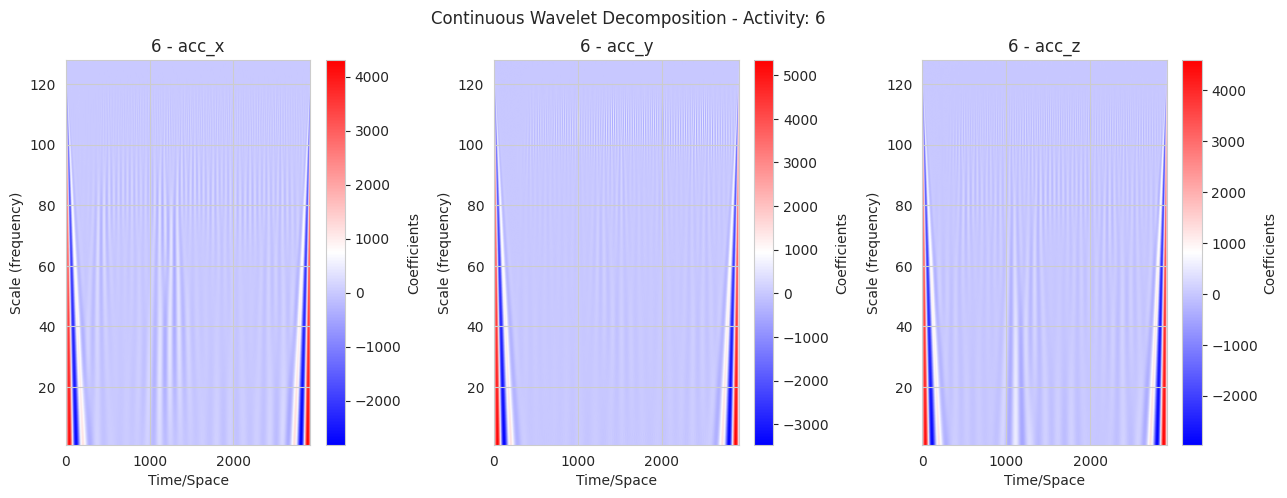

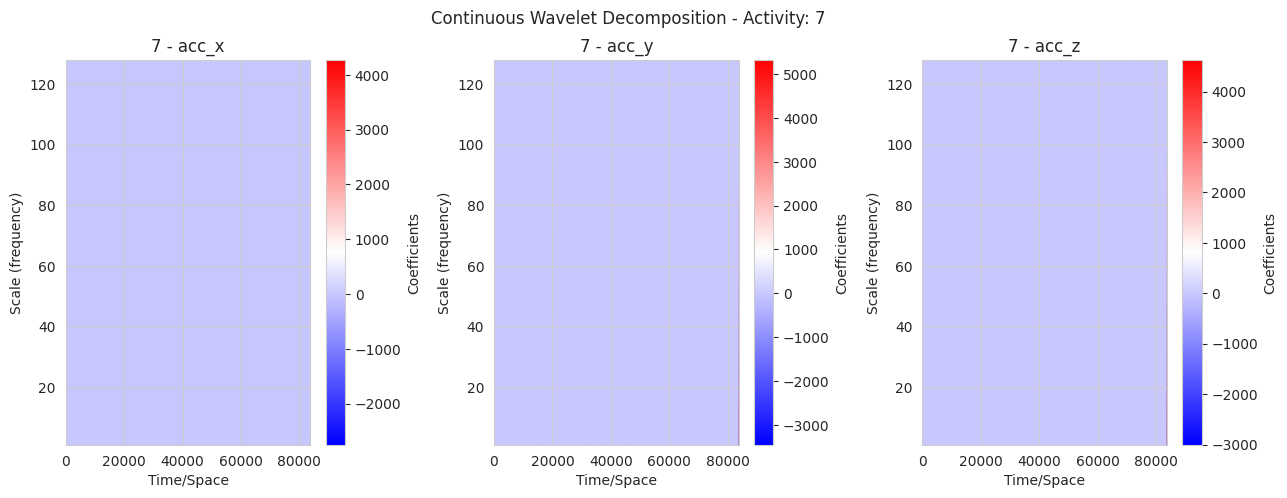

In [14]:
# Define wavelet parameters
wavelet = 'morl'  # 'mexh' Mexican Hat wavelet, 'morl' Morlet Wavelet
scales = np.arange(1, 128)

# Plot CWD for each activity and accelerometer channel
# loop su ogni attività
for activity in activities:
    # filtra i dati per attività
    df_activity = df[df['Activity'] == activity]
    time_series = np.linspace(0, len(df_activity), len(df_activity))
    plt.figure(figsize=(15, 5))

    # loop su ogni canale dell'accelerometro
    for i, channel in enumerate(channels):
        # estraggo i dati di un canale
        signal = df_activity[channel].values
        # calcolo la CWT
        coefficients, frequencies = pywt.cwt(signal, scales, wavelet)

        # creazione del sottografico
        plt.subplot(1, 3, i+1)
        #sns.heatmap(np.abs(coefficients), cmap='viridis')
        #plt.title(f'{activity} - {channel}')
        #plt.xlabel('Time')
        #plt.ylabel('Scale')
        plt.imshow(coefficients, aspect="auto", extent=[0, len(signal), 1, 128], cmap="bwr")
        plt.colorbar(label="Coefficients")  # Aggiungi barra dei colori
        plt.title(f"{activity} - {channel}")
        plt.xlabel("Time/Space")
        plt.ylabel("Scale (frequency)")

    # Aggiungi spazio tra i grafici
    plt.subplots_adjust(wspace=0.4)  # Aumenta la distanza tra i subplot

    plt.suptitle(f'Continuous Wavelet Decomposition - Activity: {activity}')
    plt.show()

Continuous Wavelet Transform (CWT) applied to the 3 accelerometer signals (acc_x, acc_y, acc_z)  of a givent activity, 3 images for each of the 7 activity.
Wavelet Decomposition: The x-axis (Time/Space) represents the time progression of the signal. Time in this case. The y-axis (Scale/Frequency) represents the frequency content (higher scales correspond to lower frequencies). The color intensity (blue to red) represents the magnitude of the wavelet coefficients:
- Red regions indicate strong positive correlations at that scale.
- Blue regions indicate strong negative correlations.
- Light blue/white regions suggest low activity or neutral values.

Concentrating on activity 2:
- General Observations

  - The strong edges at the beginning and end of the signals (red and blue bands) indicate that there are high-magnitude changes at those points. This suggests either abrupt motion or an artifact due to data boundaries.
  - The dominance of lower frequencies (higher scales) means the signal is relatively smooth, and high-frequency variations are less prominent.
  - The three channels (x, y, z) show similar patterns, suggesting the movement is relatively uniform across all axes.


In [15]:
import os
print(os.getcwd())


/content


# Results

# Final considerations